In [423]:
%%html
<style>
table {float:left}
</style>

# Analyzing-Network-Traffic_kdd99 - EDA / Data Cleaning

Workflow:  using Jupyter notebooks as notes, along with a python class where functions will be written.

In [424]:
# my python files
import src.analytics as tics
import src.plotting_functions as pltfuncs
import src.transforms as trans

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import kendalltau
print(pltfuncs)
print(tics)

<module 'src.plotting_functions' from '/Users/tbot/Dropbox/0_galvanize/0_TODAY/Analyzing-Network-Traffic_kdd99/src/plotting_functions.py'>
<module 'src.analytics' from '/Users/tbot/Dropbox/0_galvanize/0_TODAY/Analyzing-Network-Traffic_kdd99/src/analytics.py'>


1- create gh repo
	- get .gitignore

2- create Jupyter Notebook for data

3- create a python class and import it into jupyter

--- commit

4- pull down the data into the repo
    - modify gitignore to ignore the data
--- commit

### write function to use bash to create samples from the data set

-- commit

In [425]:
# On OSX requires brew install coreutils, using gshuf instead of shuf
sample_name = 'data/sample_random_subset.csv'

tics.create_random_samples('data/kddcup.data', 10000, sample_name)

### Get some Initial metrics

In [426]:
# more imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### As the name list that accompanies the data set did not have all the field names, I cross referenced with a `sql` file at https://github.com/myui/hivemall/wiki/KDD-cup-1999-network-intrusion-dataset-%231 .  This matched the order displayed with the data set as well as with other tables out on the webs.

In [427]:
# Create list of column names
columns = ['duration',
           'protocol_type',
           'service',
           'flag',
           'src_bytes',
           'dst_bytes',
           'land',
           'wrong_fragment',
           'urgent',
           'hot',
           'num_failed_logins',
           'logged_in',
           'num_compromised',
           'root_shell',
           'su_attempted',
           'num_root',
           'num_file_creations',
           'num_shells',
           'num_access_files',
           'num_outbound_cmds',
           'is_host_login',
           'is_guest_login',
           'count',
           'srv_count',
           'serror_rate',
           'srv_serror_rate',
           'rerror_rate',
           'srv_rerror_rate',
           'same_srv_rate',
           'diff_srv_rate',
           'srv_diff_host_rate',
           'dst_host_count',
           'dst_host_srv_count',
           'dst_host_same_srv_rate',
           'dst_host_diff_srv_rate',
           'dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate',
           'dst_host_serror_rate',
           'dst_host_srv_serror_rate',
           'dst_host_rerror_rate',
           'dst_host_srv_rerror_rate',
           'label']
df = pd.read_csv(sample_name, header=None)
# df = pd.read_csv('data/kddcup.data_10_percent')
df.columns = columns
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,300,2251,0,0,0,0,...,255,1.00,0.00,0.01,0.00,0.0,0.0,0.0,0.0,normal.
1,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
2,0,tcp,http,SF,224,3280,0,0,0,0,...,255,1.00,0.00,0.11,0.02,0.0,0.0,0.0,0.0,normal.
3,0,tcp,private,REJ,0,0,0,0,0,0,...,9,0.04,0.07,0.00,0.00,0.0,0.0,1.0,1.0,neptune.
4,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.


In [428]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,10000.000000,1.000000e+04,1.000000e+04,10000.0,10000.0000,10000.0,10000.000000,10000.0,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,46.735500,9.040011e+02,6.649342e+02,0.0,0.0001,0.0,0.014200,0.0,0.146900,0.072400,...,233.480900,190.117800,0.757313,0.029797,0.605995,0.006380,0.175446,0.175362,0.056350,0.056277
std,652.121874,2.202247e+04,1.838377e+04,0.0,0.0100,0.0,0.499623,0.0,0.354024,7.160048,...,63.132673,105.260117,0.408977,0.106460,0.481375,0.042074,0.379680,0.380055,0.227803,0.228273
min,0.000000,0.000000e+00,0.000000e+00,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.050000e+02,0.000000e+00,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.000000,...,255.000000,70.000000,0.510000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,23829.000000,2.194619e+06,1.812556e+06,0.0,1.0000,0.0,30.000000,0.0,1.000000,716.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [429]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 42 columns):
duration                       10000 non-null int64
protocol_type                  10000 non-null object
service                        10000 non-null object
flag                           10000 non-null object
src_bytes                      10000 non-null int64
dst_bytes                      10000 non-null int64
land                           10000 non-null int64
wrong_fragment                 10000 non-null int64
urgent                         10000 non-null int64
hot                            10000 non-null int64
num_failed_logins              10000 non-null int64
logged_in                      10000 non-null int64
num_compromised                10000 non-null int64
root_shell                     10000 non-null int64
su_attempted                   10000 non-null int64
num_root                       10000 non-null int64
num_file_creations             10000 non-null int64
num_s

##### Observe uniques for each object type

In [430]:
df['protocol_type'].unique()

unique_vals_per_column = tics.count_column_uniques(df)

for k, v in unique_vals_per_column.items():
    print('{}: {}\n'.format(k, v))


protocol_type: ['tcp', 'icmp', 'udp']

service: ['http', 'ecr_i', 'private', 'name', 'ftp_data', 'smtp', 'sunrpc', 'nnsp', 'other', 'login', 'eco_i', 'printer', 'domain_u', 'telnet', 'systat', 'efs', 'ctf', 'link', 'ntp_u', 'urp_i', 'finger', 'ldap', 'vmnet', 'uucp', 'domain', 'klogin', 'hostnames', 'imap4', 'daytime', 'auth', 'ftp', 'netbios_ns', 'pop_2', 'Z39_50', 'netstat', 'remote_job', 'whois', 'echo', 'supdup', 'shell', 'bgp', 'IRC', 'iso_tsap', 'pop_3', 'time', 'ssh', 'netbios_ssn', 'csnet_ns', 'kshell', 'http_443', 'uucp_path', 'discard', 'exec', 'nntp', 'netbios_dgm']

flag: ['SF', 'REJ', 'S0', 'RSTR', 'S3', 'RSTO', 'S2', 'S1', 'SH']

label: ['normal.', 'smurf.', 'neptune.', 'portsweep.', 'nmap.', 'ipsweep.', 'back.', 'satan.', 'pod.']



##### Count number of zero values in each column

The motivation here is to see if which of the features are contributing little to the y

In [431]:
zero_counts = tics.count_zeros_ratio(df)
zero_counts

{'count': [0.0, 0],
 'dst_bytes': [0.8261, 8261],
 'dst_host_count': [0.0, 0],
 'dst_host_srv_count': [0.0, 0],
 'duration': [0.9736, 9736],
 'flag': [0.0, 0],
 'hot': [0.9979, 9979],
 'is_guest_login': [0.9993, 9993],
 'is_host_login': [1.0, 10000],
 'label': [0.0, 0],
 'land': [1.0, 10000],
 'logged_in': [0.8531, 8531],
 'num_access_files': [0.9989, 9989],
 'num_compromised': [0.9991, 9991],
 'num_failed_logins': [1.0, 10000],
 'num_file_creations': [0.9999, 9999],
 'num_outbound_cmds': [1.0, 10000],
 'num_root': [0.9989, 9989],
 'num_shells': [0.9997, 9997],
 'protocol_type': [0.0, 0],
 'root_shell': [0.9998, 9998],
 'service': [0.0, 0],
 'src_bytes': [0.2314, 2314],
 'srv_count': [0.0, 0],
 'su_attempted': [0.9999, 9999],
 'urgent': [1.0, 10000],
 'wrong_fragment': [0.9999, 9999]}

In [432]:
print(tics.count_zeros_message(df))

At 10000 samples:
   land has only zero values
   urgent has only zero values
   num_failed_logins has only zero values
   num_outbound_cmds has only zero values
   is_host_login has only zero values



```
At 1000 samples:
   land has only zero values
   urgent has only zero values
   num_failed_logins has only zero values
   root_shell has only zero values
   su_attempted has only zero values
   num_root has only zero values
   num_shells has only zero values
   num_access_files has only zero values
   num_outbound_cmds has only zero values
   is_host_login has only zero values

At 10000 samples:
   land has only zero values
   urgent has only zero values
   num_failed_logins has only zero values
   root_shell has only zero values
   su_attempted has only zero values
   num_shells has only zero values
   num_outbound_cmds has only zero values
   is_host_login has only zero values
   
At 50000 samples:
   su_attempted has only zero values
   num_outbound_cmds has only zero values
   is_host_login has only zero values
   
At 250000 samples:
   urgent has only zero values
   num_outbound_cmds has only zero values
   is_host_login has only zero values
 
At 500000 samples:
   num_outbound_cmds has only zero values
   is_host_login has only zero values
```

### Some Histograms

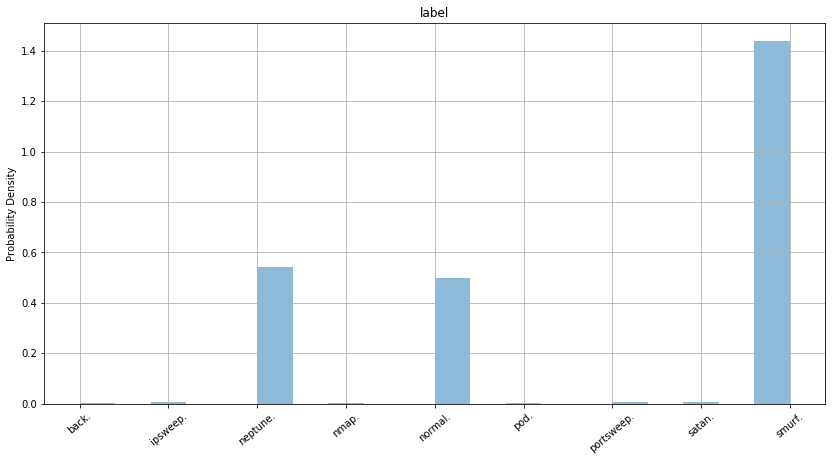

In [433]:
pltfuncs.plot_hist_basic(df, 'label')

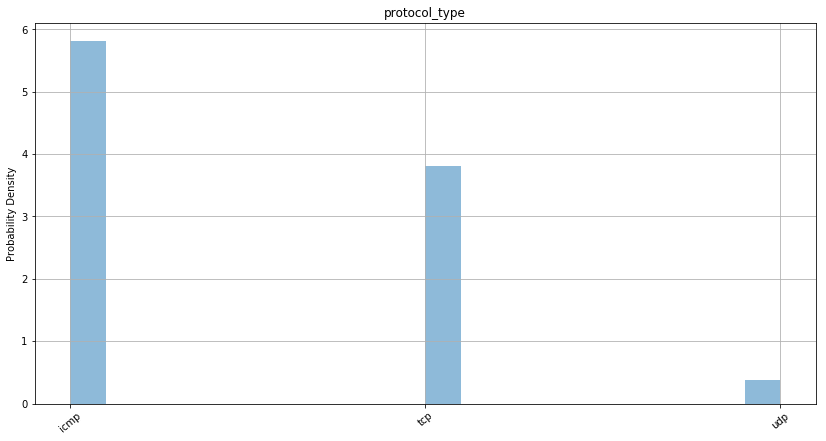

In [434]:
pltfuncs.plot_hist_basic(df, 'protocol_type')

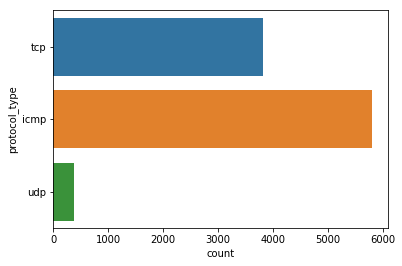

In [435]:
sns_plt = sns.countplot(y=df["protocol_type"])

### ICMP
(from wikipedia): is used by network devices, including routers, to send error messages and operational information indicating, for example, that a requested service is not available or that a host or router could not be reached. ICMP differs from transport protocols such as TCP and UDP in that it is not typically used to exchange data between systems, nor is it regularly employed by end-user network applications


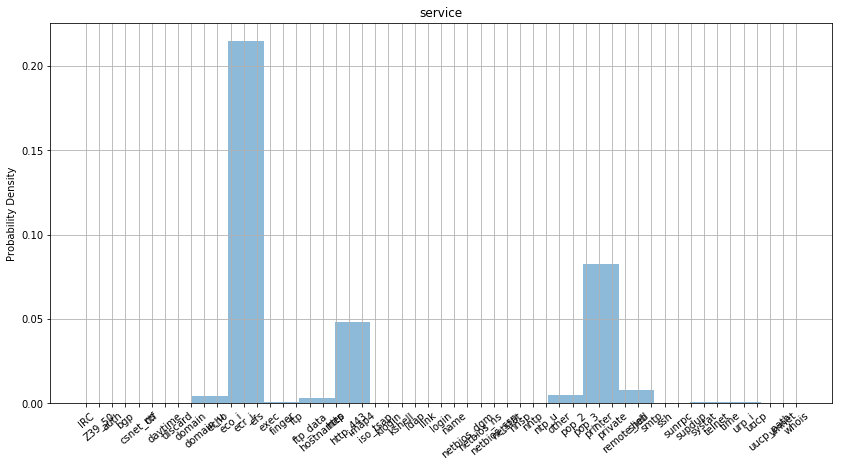

In [436]:
pltfuncs.plot_hist_basic(df, 'service')

In [437]:
# plot num_compromised against label?

# x_axis = df.label
# y_axis = df['num_compromised'].values

# plt.figure()
# plt.plot(x_axis, y_axis, 'r')
# plt.xlabel('Label')
# plt.ylabel('num_compromised')
# plt.title('Count of compromised per Label')
# plt.xticks(rotation=40)

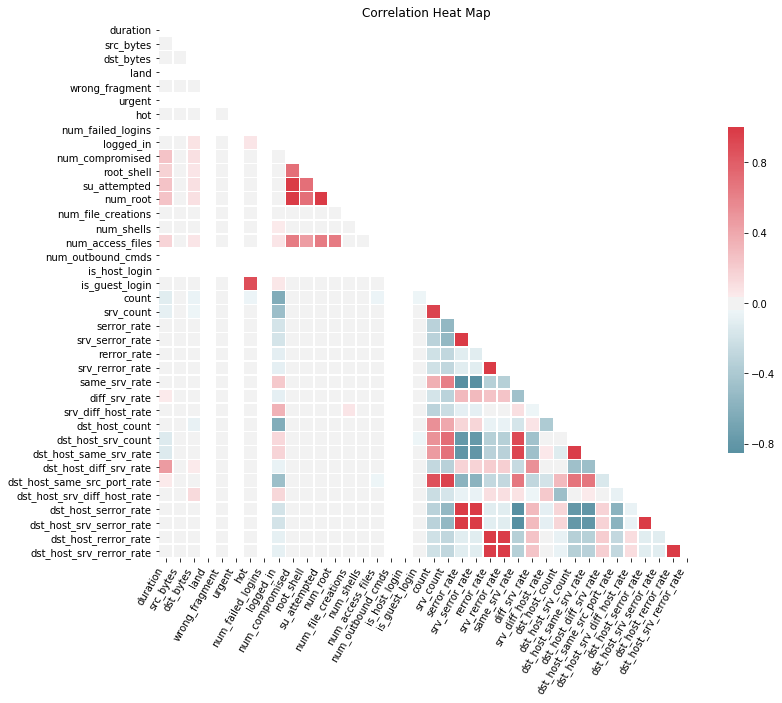

In [438]:
pltfuncs.corr_heat(df)

In [439]:
# unique values
df.label.unique()


array(['normal.', 'smurf.', 'neptune.', 'portsweep.', 'nmap.', 'ipsweep.',
       'back.', 'satan.', 'pod.'], dtype=object)

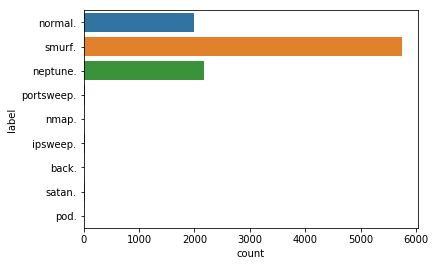

In [440]:
sns_plt = sns.countplot(y=df["label"])


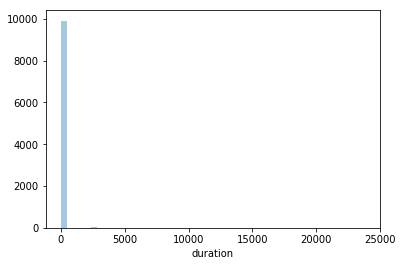

In [441]:
sns_plt = sns.distplot(df["duration"], kde=False)


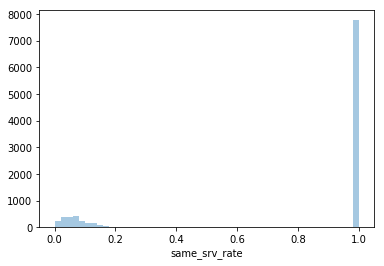

In [442]:
sns_plt = sns.distplot(df["same_srv_rate"], kde=False)


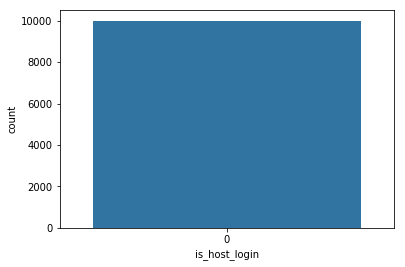

In [443]:
sns_plt = sns.countplot(x=df["is_host_login"])


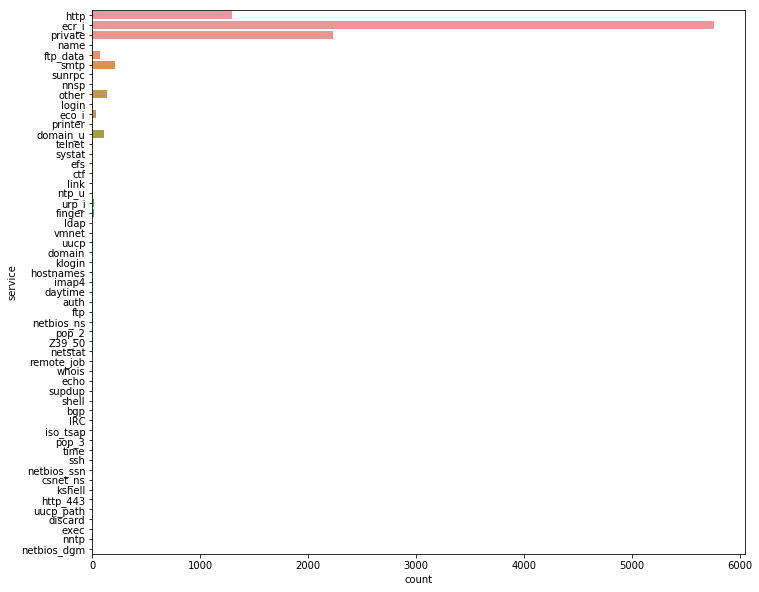

In [444]:
a4_dims = (11.7, 10)
fig, ax = plt.subplots(figsize=a4_dims)

sns_plt = sns.countplot(ax=ax,
                        y=df["service"])

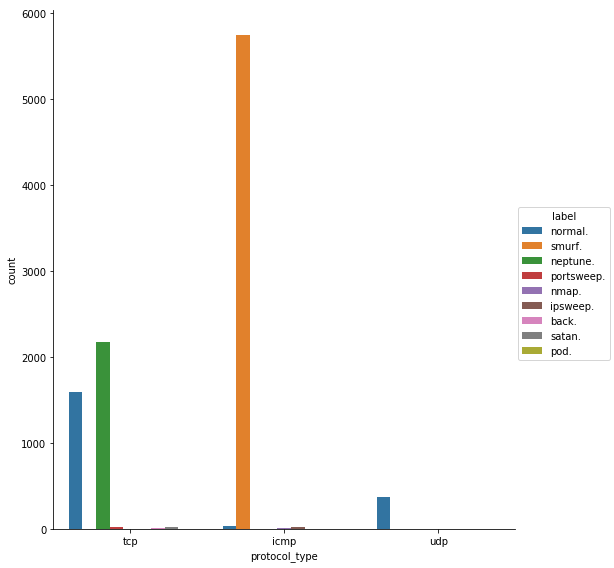

In [445]:
sns_plt = sns.factorplot(x='protocol_type', 
                         hue='label',
                         data=df,
                         kind='count',
                         size=8,

                         aspect=.9)

Note the large amount of Smurf attacks over ICMP protocol:

Smurf is a DDOS attack where large numbers of ICMP packets are broadcast to a computer network using the IP's broadcast address.  In the late 1990s, many IP networks would participate in Smurf attacks by responding to ICMP requests. The name comes from the idea of very small, but numerous, attackers overwhelming a much larger opponent 

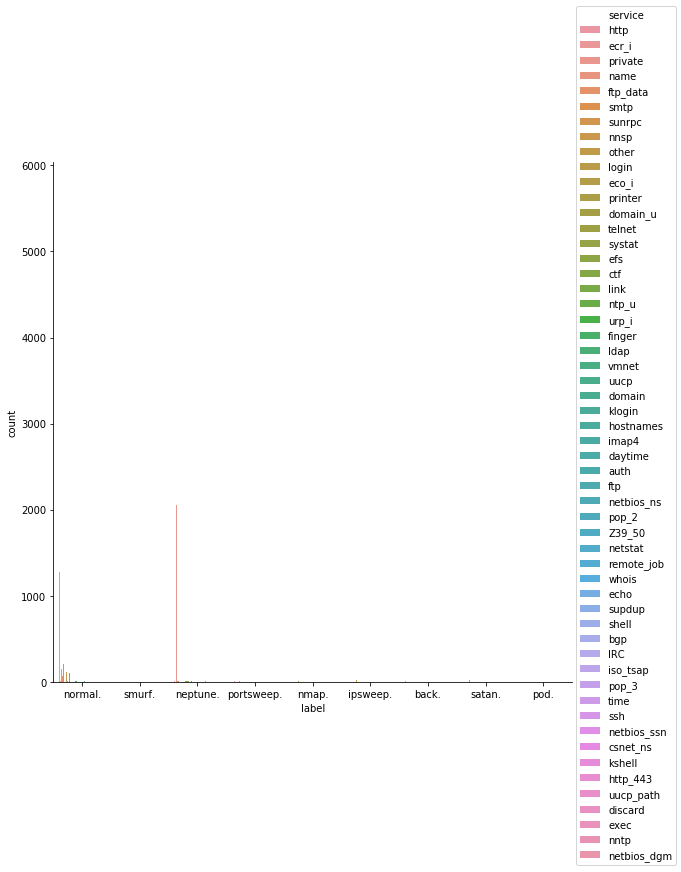

In [446]:
sns_plt = sns.factorplot(x='label', 
                         hue='service',
                         data=df,
                         kind='count',
                         size=8,

                         aspect=1)

### Categories of Attacks
- normal: (0) no attack occurred

Attacks fall into four main categories:
- probe: (1)surveillance and other probing, e.g., port scanning.
- DOS  : (2) denial-of-service, e.g. syn flood;
- U2R  : (3) unauthorized access to local superuser (root) privileges, e.g., various `buffer overflow` attacks;
- R2L  : (4) unauthorized access from a remote machine, e.g. guessing password;




Additionally, there are attack labels in the Test data that are different from the labels in the Training data.

##### Mapping for Attacks to Categories
(thanks to https://cseweb.ucsd.edu/~elkan/tabulate.html)



##### normal connection


| label   |        |Category #|
|--------|--------|----------|
|normal. | normal |(0)       |


##### attack types in testing data

| label   | Attack Type | Category # |
|--------|-------------|------------|
|apache2. | DOS |(2)| 
|back. | DOS |(2)| 
|buffer_overflow. | U2R |(3)| 
|ftp_write. |  R2L |(4)| 
|guess_passwd. |  R2L |(4)| 
|httptunnel. |  R2L |(4)| 
|httptunnel. | U2R |(3)| 
|imap. |  R2L |(4)| 
|ipsweep. | probe |(1)| 
|land. | DOS |(2)| 
|loadmodule. | U2R |(3)| 
|mailbomb. | DOS |(2)| 
|mscan. | probe |(1)| 
|multihop. |  R2L |(4)| 
|multihop. | U2R |(3)| # duplicate
|named. |  R2L |(4)| 
|neptune. | DOS |(2)| 
|nmap. | probe |(1)| 
|perl. | U2R |(3)| 
|phf. |  R2L |(4)| 
|pod. | DOS |(2)| 
|portsweep. | probe |(1)| 
|processtable. | DOS |(2)| 
|ps. | U2R |(3)| 
|rootkit. | U2R |(3)| 
|saint. | probe |(1)| 
|satan. | probe |(1)| 
|sendmail. |  R2L |(4)| 
|smurf. | DOS |(2)| 
|snmpgetattack. |  R2L |(4)| 
|snmpguess. |  R2L |(4)| 
|sqlattack. | U2R |(3)| 
|teardrop. | DOS |(2)| 
|udpstorm. | DOS |(2)| 
|warezmaster. | DOS |(2)| 
|worm. |  R2L |(4)| 
|xlock. |  R2L |(4)| 
|xsnoop. |  R2L |(4)| 
|xterm. | U2R |(3)|




##### attack types in training data

|label   | Attack Type | Category # |
|--------|-------------|------------|
|back. | DOS |(2)| 
|buffer_overflow. | U2R |(3)| 
|ftp_write. |  R2L |(4)| 
|guess_passwd. |  R2L |(4)| 
|imap. |  R2L |(4)| 
|ipsweep. | probe |(1)| 
|land. | DOS |(2)| 
|loadmodule. | U2R |(3)| 
|multihop. |  R2L |(4)| 
|neptune. | DOS |(2)| 
|nmap. | probe |(1)| 
|perl. | U2R |(3)| 
|phf. |  R2L |(4)| 
|pod. | DOS |(2)| 
|portsweep. | probe |(1)| 
|rootkit. | U2R |(3)| 
|satan. | probe |(1)| 
|smurf. | DOS |(2)| 
|spy. |  R2L |(4)| 
|teardrop. | DOS |(2)| 
|warezclient. |  R2L |(4)| 


## Transforming data

### putting labels into their categories, categorical number
- Normal : 0
- probe: 1
- DOS : 2
- U2R : 3
- R2L : 4

In [447]:
# read in label names csv and send it as dictionary to mapping function
label_names = ['label', 'attack_category', 'attack_cat_num']
labels_loc = 'data/categories.csv'
labels_to_categories = pd.read_csv(labels_loc, header=None)
labels_to_categories.columns = label_names
column_name = 'label'

df2 = trans.rewrite_values(df, dict(zip(labels_to_categories.label, labels_to_categories.attack_cat_num)), column_name)
# labels_to_categories.info()


In [448]:
df2.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,300,2251,0,0,0,0,...,255,1.00,0.00,0.01,0.00,0.0,0.0,0.0,0.0,0
1,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,2
2,0,tcp,http,SF,224,3280,0,0,0,0,...,255,1.00,0.00,0.11,0.02,0.0,0.0,0.0,0.0,0
3,0,tcp,private,REJ,0,0,0,0,0,0,...,9,0.04,0.07,0.00,0.00,0.0,0.0,1.0,1.0,2
4,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,2


### changing protocols to categorical number

In [449]:
df2['protocol_type'].unique()

array(['tcp', 'icmp', 'udp'], dtype=object)

In [456]:
column_name = 'protocol_type'
mapping = list(df2[column_name].unique())

df3 = trans.my_create_dummies(df2, mapping, column_name)


In [459]:
df3.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,tcp,icmp,udp
0,0,tcp,http,SF,300,2251,0,0,0,0,...,0.01,0.00,0.0,0.0,0.0,0.0,0,1,0,0
1,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,1.00,0.00,0.0,0.0,0.0,0.0,2,0,1,0
2,0,tcp,http,SF,224,3280,0,0,0,0,...,0.11,0.02,0.0,0.0,0.0,0.0,0,1,0,0
3,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,1.0,1.0,2,1,0,0
4,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,1.00,0.00,0.0,0.0,0.0,0.0,2,0,1,0


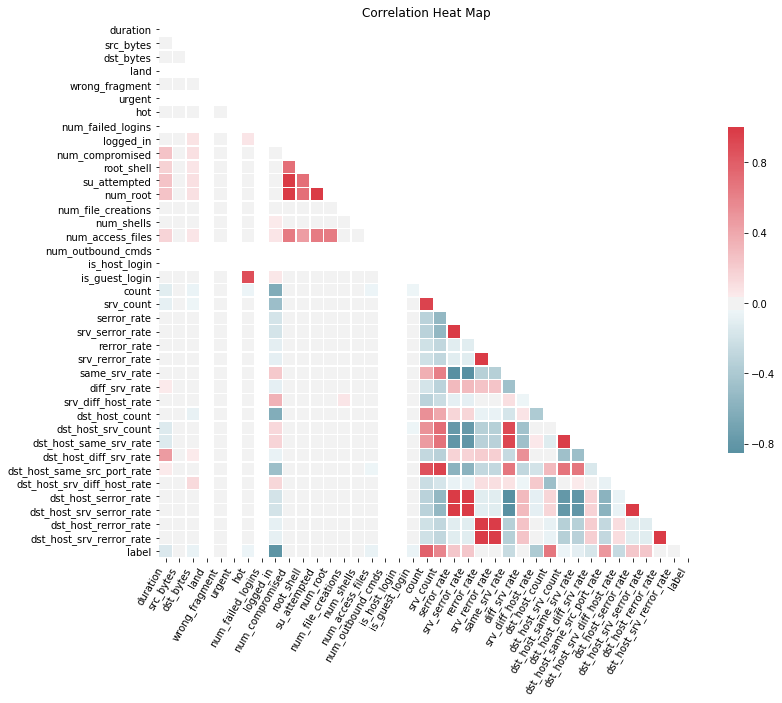

In [460]:
pltfuncs.corr_heat(df2)

In [463]:
sns.set(style="ticks")

sns.pairplot(df3, hue="protocol_type")

In [ ]:
_ = pd.scatter_matrix(wine.loc[:, 'Alcohol':'Flavanoids'], figsize=(14,14), diagonal='kde')